- callback 3 epochs


In [ ]:
!pip install keras_cv

In [ ]:
import random

import keras
import keras_cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

Using TensorFlow backend


In [ ]:
import zipfile

with zipfile.ZipFile('./drive/MyDrive/data/dataset_underwater.zip') as fh:
  fh.extractall()

In [ ]:
import zipfile

with zipfile.ZipFile('./drive/MyDrive/data/TEST.zip') as fh:
  fh.extractall()

In [ ]:
import glob

images = sorted(glob.glob('./dataset_underwater/dataset/images/*.jpg'))
masks = sorted(glob.glob('./dataset_underwater/dataset/masks/*.bmp'))

images_test = sorted(glob.glob('./TEST/images/*.jpg'))
masks_test = sorted(glob.glob('./TEST/masks/*.bmp'))

In [ ]:
images_test[0]

'./TEST/images/d_r_122_.jpg'

In [ ]:
import tensorflow as tf

# Image Config
HEIGHT = 160
WIDTH = 160
NUM_CLASSES = 8
IMG_SHAPE = (HEIGHT, WIDTH)

# Augmentation Config
ROTATION_FACTOR = (-0.2, 0.2)

# Training Config
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
import os
import cv2
import numpy as np

binary_encoded = [[0, 0, 0],[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]

anno_labels = []


for idx, filename in enumerate(masks):
  mask =  cv2.imread(filename)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)//255

  AnnMap = np.zeros(mask.shape[0:2], np.float32)

  for i, label in enumerate(binary_encoded):
    AnnMap[np.all(mask == label, axis=-1)] = float(i)

  AnnMap = cv2.resize(AnnMap, IMG_SHAPE)
  anno_labels.append(AnnMap)

In [ ]:
anno_labels_test = []

for idx, filename in enumerate(masks_test):
  mask =  cv2.imread(filename)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)//255

  AnnMap = np.zeros(mask.shape[0:2], np.float32)

  for i, label in enumerate(binary_encoded):
    AnnMap[np.all(mask == label, axis=-1)] = float(i)

  AnnMap = cv2.resize(AnnMap, IMG_SHAPE)
  anno_labels_test.append(AnnMap)

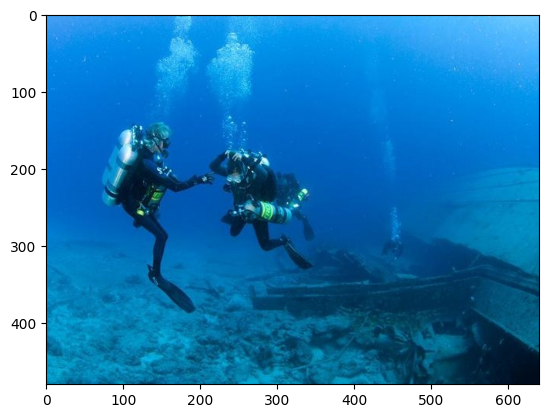

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB))

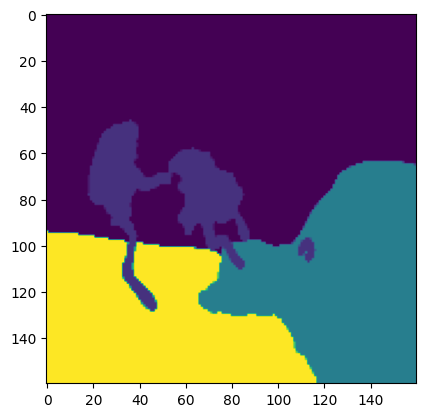

In [ ]:
plt.imshow(anno_labels[0])

In [ ]:
import tensorflow as tf

#Функция для загрузки изображения
def load_img(image_path, mask):
    #Загружаем и препроцессим изображения
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, IMG_SHAPE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.

    #Загружаем и препроцессим маски изображений
    # print(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.expand_dims(mask, axis=-1)

    return image, mask

#Аугментация изобажений
def aug_img(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    image = tf.image.resize(image, IMG_SHAPE)
    masks = tf.image.resize(masks, IMG_SHAPE)
    return image, masks

In [ ]:
def package_outputs(image, segmentation_mask):
    outputs = dict()
    outputs['images'] = image
    outputs["segmentation_masks"] = segmentation_mask
    return outputs

def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

In [ ]:
dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images),
                               tf.data.Dataset.from_tensor_slices(anno_labels)))

dataset = dataset.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
ds = dataset.map(package_outputs, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_len, val_len = int(len(images)*0.8), int(len(images)*0.2)

ds.shuffle(buffer_size = len(images), seed=42)

train_ds = ds.take(train_len)
val_ds = ds.skip(train_len)

In [ ]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

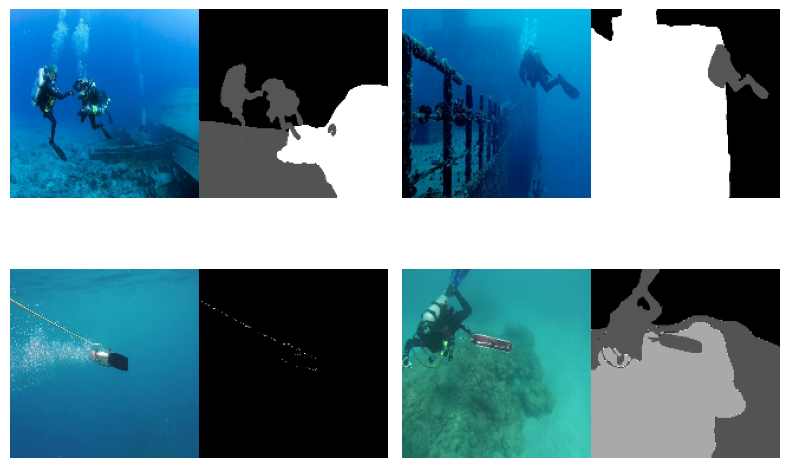

In [ ]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(4)
images, segmentation_masks = next(iter(plot_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

In [ ]:
augment_fn = keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomRotation(
            factor=ROTATION_FACTOR,
            segmentation_classes=NUM_CLASSES,
        ),
        keras_cv.layers.RandAugment(
            value_range=(0, 1.0),
            geometric=False,
        ),
    ]
)

In [ ]:
augmented_train_ds = (
    train_ds.shuffle(BATCH_SIZE * 2)
    # .map(augment_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

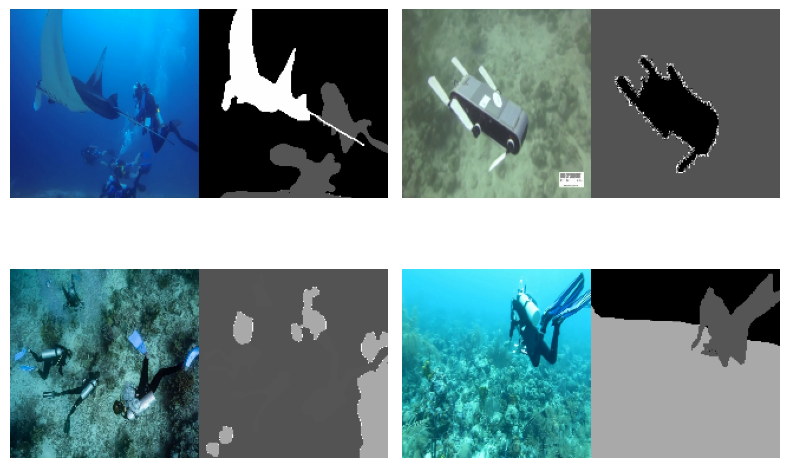

In [ ]:
images, segmentation_masks = next(iter(augmented_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Taking a batch of test inputs to measure model's progress.
test_images, test_masks = next(iter(val_ds))

In [ ]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            pred_masks = self.model.predict(test_images)
            pred_masks = tf.math.argmax(pred_masks, axis=-1)
            pred_masks = pred_masks[..., tf.newaxis]

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = pred_masks[random_index]
            random_true_mask = test_masks[random_index]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image: {epoch:03d}")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(
                f"Predicted Mask: {epoch:03d}",
            )

            plt.show()
            plt.close()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
callbacks = [DisplayCallback(5), callback]

Epoch 1/50
76/77 [============================>.] - ETA: 0s - loss: 2.0112 - accuracy: 0.5597 - global IoU: 0.1877 - class 0: 0.5516 - class 1: 0.0932 - class 2: 0.0113 - class 3: 0.0376 - class 4: 0.0139 - class 5: 0.4922 - class 6: 0.1123 - class 7: 0.1899

1/1 [==============================] - 0s 476ms/step


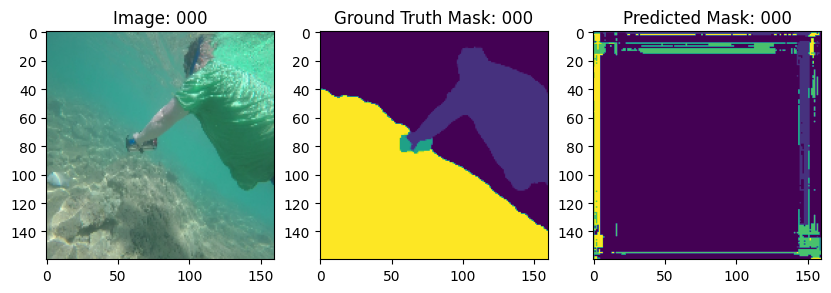

77/77 [==============================] - 37s 277ms/step - loss: 2.0086 - accuracy: 0.5598 - global IoU: 0.1879 - class 0: 0.5519 - class 1: 0.0932 - class 2: 0.0116 - class 3: 0.0375 - class 4: 0.0138 - class 5: 0.4922 - class 6: 0.1127 - class 7: 0.1902 - val_loss: 1.9583 - val_accuracy: 0.2895 - val_global IoU: 0.0457 - val_class 0: 0.2944 - val_class 1: 0.0093 - val_class 2: 6.9504e-05 - val_class 3: 5.9488e-04 - val_class 4: 0.0000e+00 - val_class 5: 0.0288 - val_class 6: 0.0000e+00 - val_class 7: 0.0324
Epoch 2/50
77/77 [==============================] - 13s 168ms/step - loss: 1.3875 - accuracy: 0.6074 - global IoU: 0.2109 - class 0: 0.6050 - class 1: 0.1230 - class 2: 0.0086 - class 3: 0.0368 - class 4: 0.0173 - class 5: 0.5354 - class 6: 0.1323 - class 7: 0.2285 - val_loss: 1.7796 - val_accuracy: 0.2852 - val_global IoU: 0.0476 - val_class 0: 0.2906 - val_class 1: 0.0021 - val_class 2: 0.0000e+00 - val_class 3: 5.9742e-04 - val_class 4: 8.4424e-05 - val_class 5: 0.0662 - val_cla

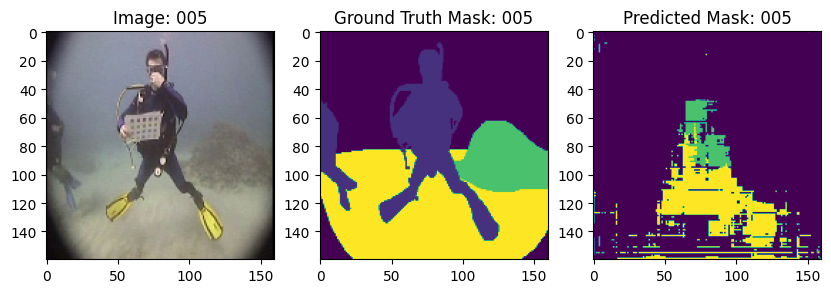

77/77 [==============================] - 19s 242ms/step - loss: 1.0922 - accuracy: 0.6562 - global IoU: 0.2340 - class 0: 0.6604 - class 1: 0.1219 - class 2: 0.0072 - class 3: 0.0156 - class 4: 0.0335 - class 5: 0.5816 - class 6: 0.1619 - class 7: 0.2901 - val_loss: 2.0216 - val_accuracy: 0.3936 - val_global IoU: 0.0981 - val_class 0: 0.3959 - val_class 1: 4.1830e-06 - val_class 2: 6.9775e-04 - val_class 3: 4.9157e-04 - val_class 4: 0.0000e+00 - val_class 5: 0.2526 - val_class 6: 0.0000e+00 - val_class 7: 0.1351
Epoch 7/50
77/77 [==============================] - 13s 163ms/step - loss: 1.0698 - accuracy: 0.6597 - global IoU: 0.2408 - class 0: 0.6719 - class 1: 0.1265 - class 2: 0.0079 - class 3: 0.0635 - class 4: 0.0286 - class 5: 0.5815 - class 6: 0.1672 - class 7: 0.2795 - val_loss: 2.1000 - val_accuracy: 0.4294 - val_global IoU: 0.1192 - val_class 0: 0.4967 - val_class 1: 0.0000e+00 - val_class 2: 8.0143e-04 - val_class 3: 8.1932e-05 - val_class 4: 0.0000e+00 - val_class 5: 0.2266 -

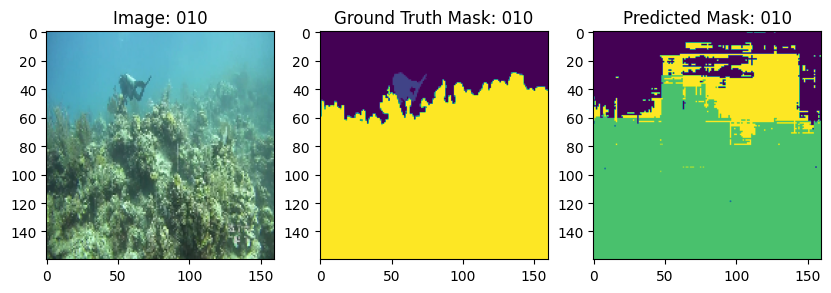

77/77 [==============================] - 14s 179ms/step - loss: 0.9742 - accuracy: 0.6827 - global IoU: 0.2641 - class 0: 0.6958 - class 1: 0.1774 - class 2: 0.0151 - class 3: 0.0521 - class 4: 0.0436 - class 5: 0.6017 - class 6: 0.2129 - class 7: 0.3139 - val_loss: 2.1083 - val_accuracy: 0.4612 - val_global IoU: 0.1611 - val_class 0: 0.5809 - val_class 1: 0.0119 - val_class 2: 0.0292 - val_class 3: 0.0012 - val_class 4: 0.0011 - val_class 5: 0.2405 - val_class 6: 0.0935 - val_class 7: 0.3304
Epoch 12/50
77/77 [==============================] - 13s 167ms/step - loss: 0.9517 - accuracy: 0.6898 - global IoU: 0.2702 - class 0: 0.7045 - class 1: 0.2024 - class 2: 0.0119 - class 3: 0.0616 - class 4: 0.0437 - class 5: 0.6103 - class 6: 0.2169 - class 7: 0.3104 - val_loss: 2.0743 - val_accuracy: 0.4614 - val_global IoU: 0.1663 - val_class 0: 0.5955 - val_class 1: 0.0245 - val_class 2: 0.0346 - val_class 3: 0.0037 - val_class 4: 0.0038 - val_class 5: 0.2363 - val_class 6: 0.0915 - val_class 7:

In [ ]:
# Build model
model = get_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy',
             tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES, name='global IoU', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[0], name='class 0', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[1], name='class 1', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[2], name='class 2', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[3], name='class 3', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[4], name='class 4', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[5], name='class 5', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[6], name='class 6', sparse_y_pred=False),
             tf.keras.metrics.IoU(num_classes=NUM_CLASSES, target_class_ids=[7], name='class 7', sparse_y_pred=False),],
)

# Train the model, doing validation at the end of each epoch.
history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
)

In [ ]:
model.save('model_semantic_segment.keras')

In [ ]:
! cp ./model_semantic_segment.keras ./drive/MyDrive/data/model_sem_seg.keras

#Eval

In [ ]:
dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images_test),
                               tf.data.Dataset.from_tensor_slices(anno_labels_test)))

dataset = dataset.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)

ds = dataset.map(package_outputs, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = (
    ds
    .batch(110)
    .map(unpackage_inputs)
)

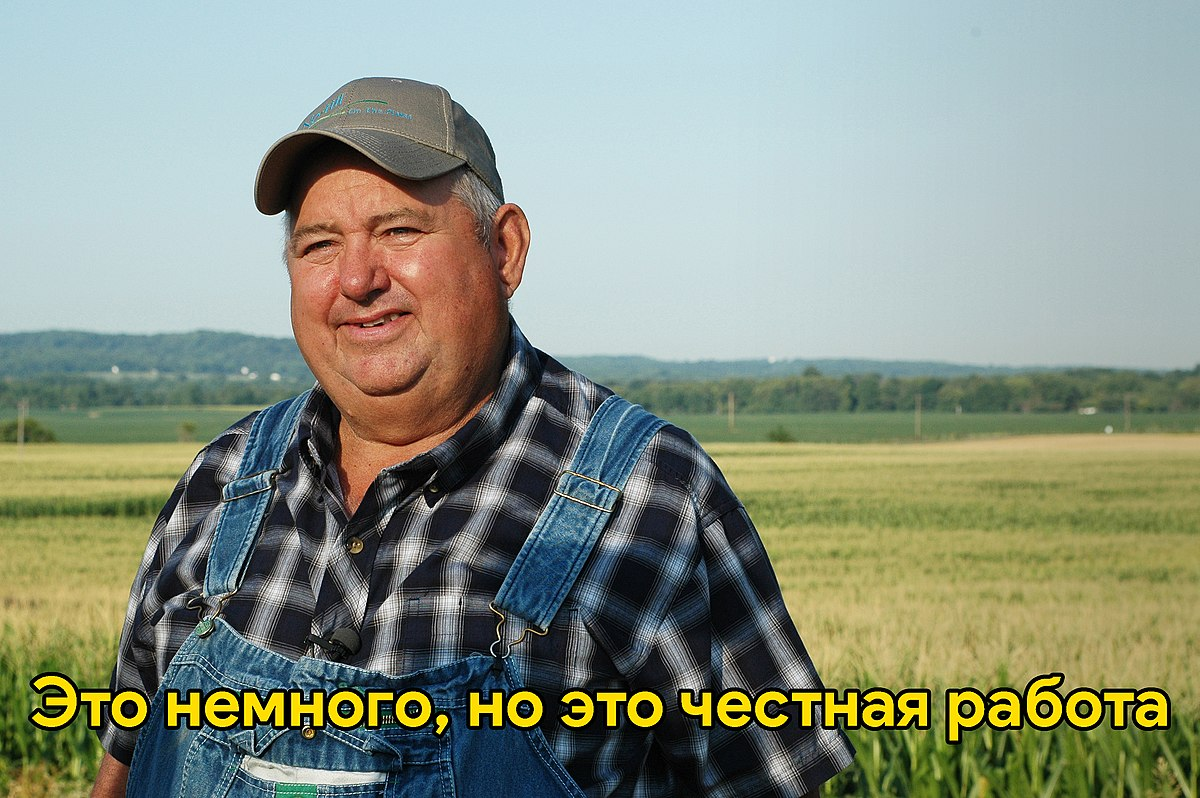

In [ ]:
model.evaluate(test_ds)

1/1 [==============================] - 5s 5s/step - loss: 1.2160 - accuracy: 0.6495 - global IoU: 0.2405 - class 0: 0.7493 - class 1: 0.0173 - class 2: 0.0316 - class 3: 0.0015 - class 4: 0.0052 - class 5: 0.4219 - class 6: 0.2140 - class 7: 0.4830


[1.2160277366638184,
 0.649458110332489,
 0.24047254025936127,
 0.7493410110473633,
 0.01725621521472931,
 0.031617388129234314,
 0.0014857989735901356,
 0.005199306644499302,
 0.4219020903110504,
 0.21397963166236877,
 0.48299896717071533]